In [1]:
# %load my_imports.ipy
# Stdlib
from functools import partial
from pprint import pprint
from itertools import chain
from math import ceil

import numpy as np
import pandas as pd

pd.set_option('display.max_columns',102)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.width',200)

import sklearn
import sklearn.linear_model
import sklearn.ensemble
from sklearn.ensemble import VotingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import cross_val_score, GridSearchCV, learning_curve, StratifiedKFold, train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

from genetic.estimator_params import params

# Visualization

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot

custom_style = {'axes.labelcolor': 'white', 'xtick.color': 'white', 'ytick.color': 'white', }
sns.set_style( rc=custom_style)
mpl.rcParams['figure.figsize']=(10,10)
plt.rcParams['figure.figsize']=(10,10)
jtplot.style('monokai')
# Custom stuff
from swozny_ml import *
from genetic.param_opt import tune_params_genetic

# Config

In [3]:
filename = 'data.csv'
index = 'shot_id'
target = 'shot_made_flag'

In [144]:
# Read data
data = pd.read_csv(filename, index_col=index)
data['Angle']=np.rad2deg(np.arctan(data.loc_y/data.loc_x).fillna(0))
data['Distance']=np.sqrt(data.loc_y**2+data.loc_x**2)
data['Angle']=pd.np.digitize(data.Angle,bins=[-91,-86,-5,5,86,91]).astype('int')
data['Distance']=pd.np.digitize(data.Distance,bins=[0,1,5,15]).astype('int')
data['minutes_remaining']=pd.np.digitize(data.minutes_remaining,bins=[0,1,5,11,15]).astype('int')
data['seconds_remaining']=pd.np.digitize(data.minutes_remaining,bins=[2,65]).astype('int')
data['period']=pd.np.digitize(data.minutes_remaining,bins=[1,2,3,4,5,10]).astype('int')

data=data.drop(['loc_x','loc_y','lat','lon','team_id','team_name','matchup','shot_distance','playoffs','game_date','combined_shot_type','game_event_id','game_id','shot_zone_range'],axis=1)
print(data.head())

               action_type  minutes_remaining  period   season  seconds_remaining  shot_made_flag       shot_type         shot_zone_area  shot_zone_basic opponent  Angle  Distance
shot_id                                                                                                                                                                            
1        Jump Shot          3                  3       2000-01  1                 NaN              2PT Field Goal  Right Side(R)          Mid-Range        POR      4      4       
2        Jump Shot          3                  3       2000-01  1                  0.0             2PT Field Goal  Left Side(L)           Mid-Range        POR      3      4       
3        Jump Shot          3                  3       2000-01  1                  1.0             2PT Field Goal  Left Side Center(LC)   Mid-Range        POR      2      4       
4        Jump Shot          3                  3       2000-01  1                  0.0             2

## Categorical

In [145]:
# Categorical
categorical = data.select_dtypes(exclude=[np.number])
for col in categorical:
    data[col]=data[col].astype('category')
categorical = data.select_dtypes(exclude=[np.number])
data['season']=data.season.cat.codes
data['opponent']=data.opponent.cat.codes
data['action_type']=data.action_type.cat.codes
data['shot_zone_area']=data.shot_zone_area.cat.codes
shot_zone_area_map=pd.qcut(data.groupby('shot_zone_area').mean()[target].sort_values(),3)
opponent_map=pd.qcut(data.groupby('opponent').mean()[target].sort_values(),4)
action_type_map=pd.qcut(data.groupby('action_type').mean()[target].sort_values(),10)
season_map = {0:0,1:0,2:1,3:1,4:1,5:1,10:1,11:1,12:1,16:1,6:2,7:2,8:2,9:1,17:3,18:3,19:3}
data['season']=data.season.map(season_map)
data['shot_zone_area']=data.shot_zone_area.map(shot_zone_area_map)
data['shot_zone_area']=data.shot_zone_area.cat.codes
data['opponent']=data.opponent.map(opponent_map)
data['opponent']=data.opponent.cat.codes
data['action_type']=data.action_type.map(action_type_map)
data['action_type']=data.action_type.cat.codes
categorical = data.select_dtypes(exclude=[np.number])
categorical.describe()

,shot_type,shot_zone_basic
count,30697,30697
unique,2,7
top,2PT Field Goal,Mid-Range
freq,24271,12625


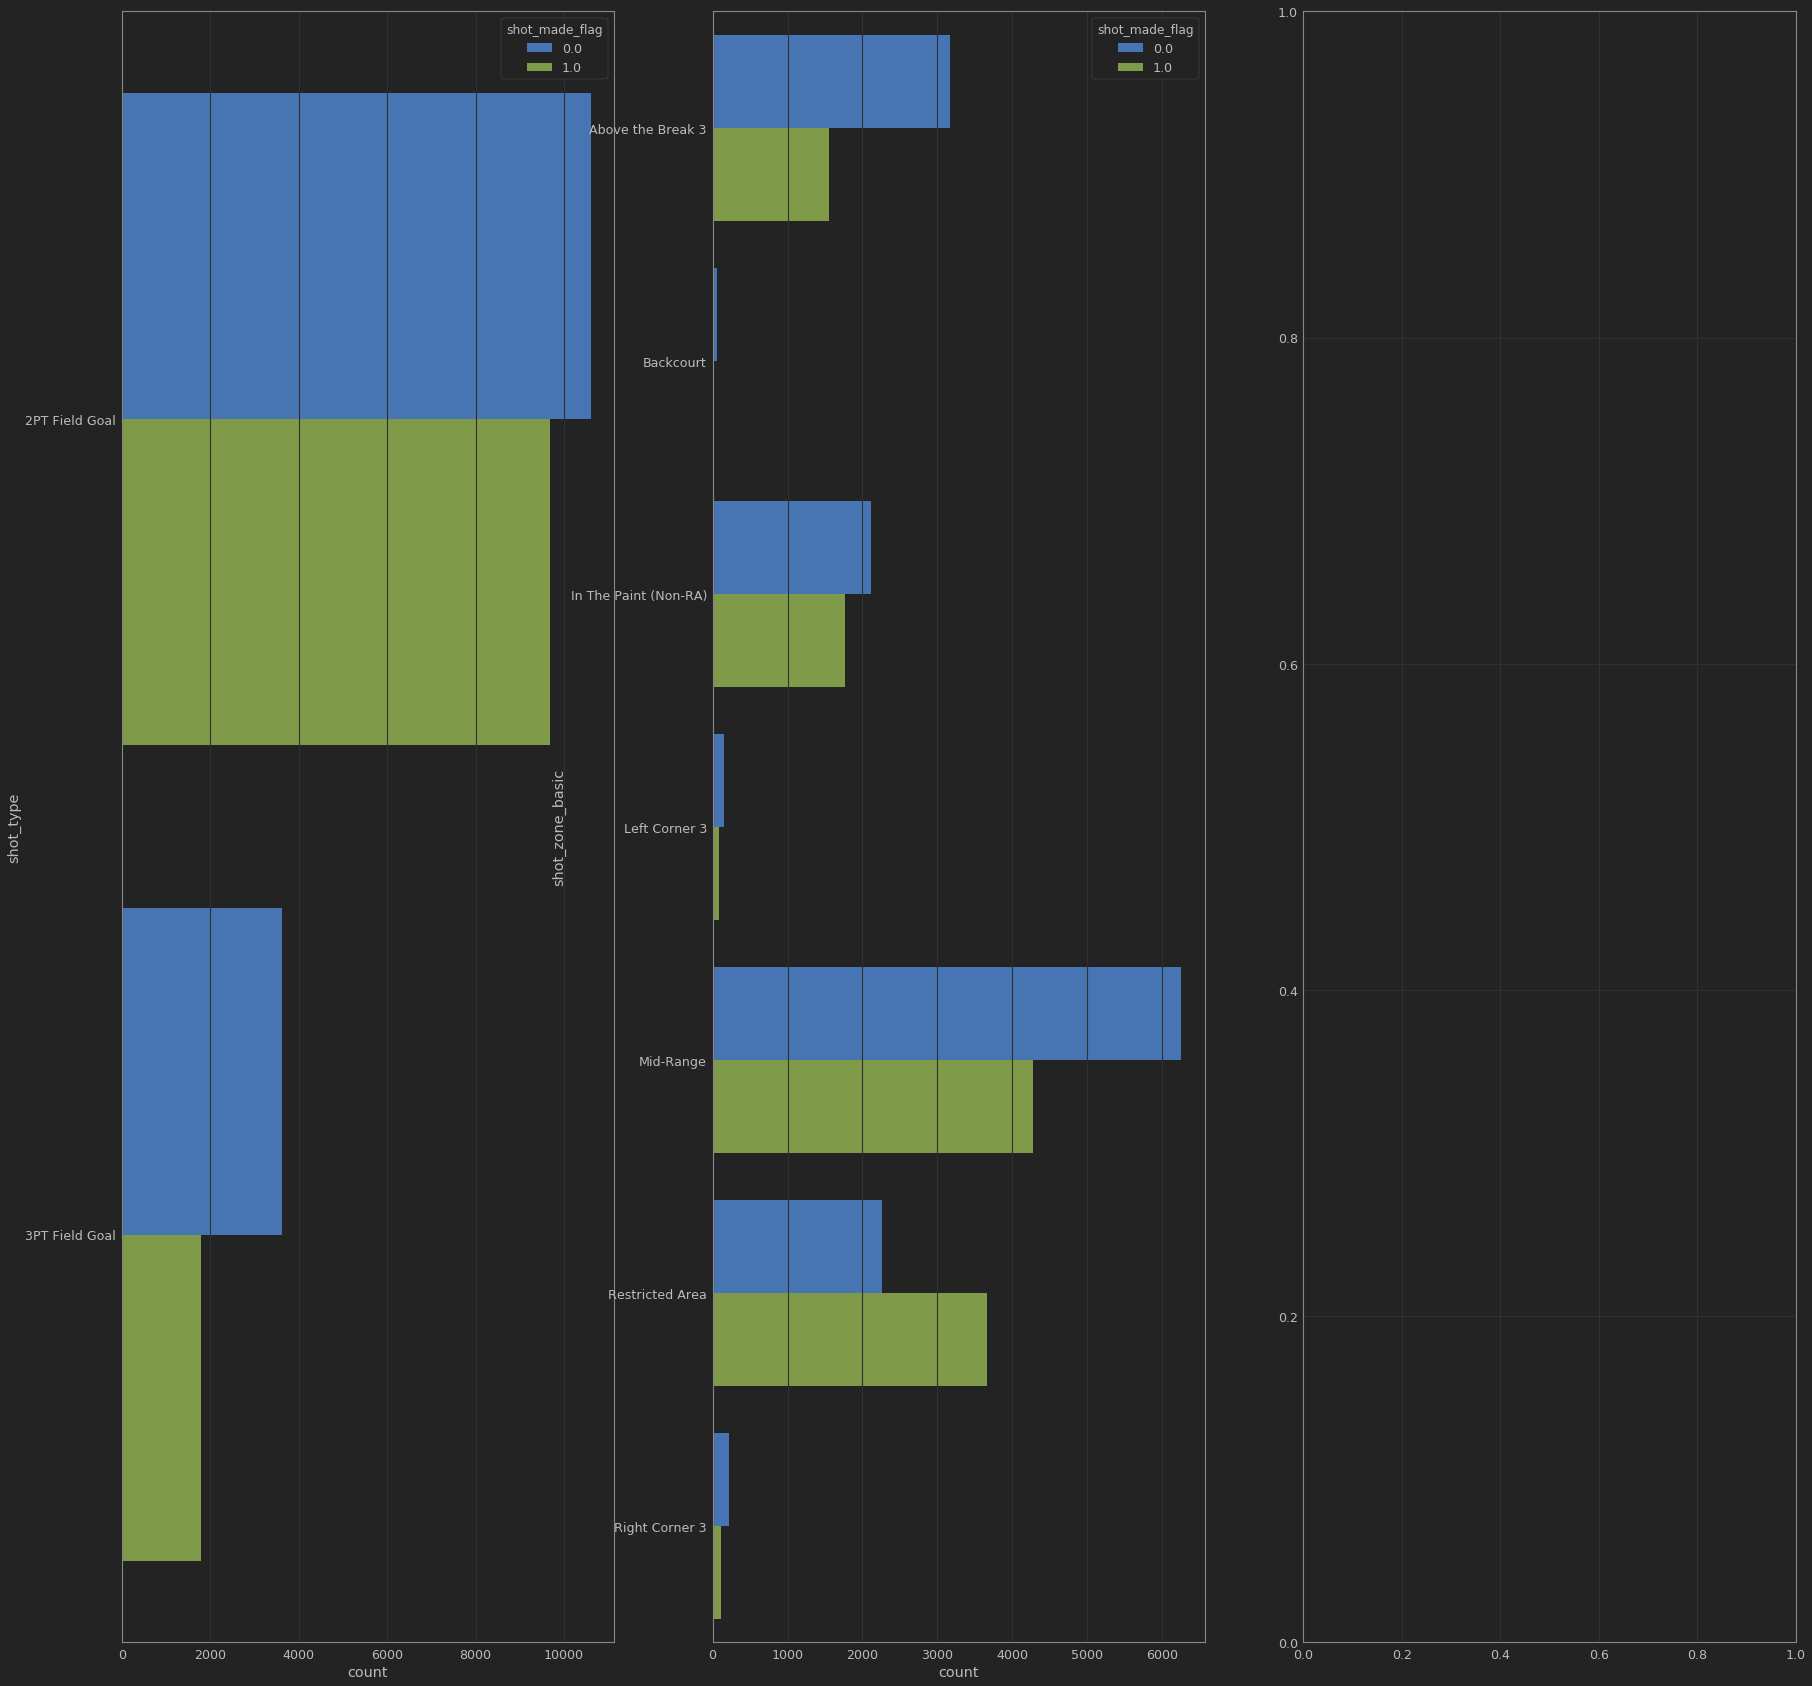

In [127]:
fig, ax = plt.subplots(ncols=3,nrows=ceil(len(categorical.columns)/3),figsize=(30,30))
for col,ax in zip(categorical.columns,chain(*ax) if False else ax):
    sns.countplot(data=data,y=col,hue=target,ax=ax)

## Numerical

In [117]:
numerical = data.select_dtypes(include=[np.number])
numerical.describe()

,action_type,minutes_remaining,period,season,seconds_remaining,shot_made_flag,shot_zone_area,opponent,Angle,Distance
count,30697.000000,30697.000000,30697.000000,25155.000000,30697.000000,25697.000000,30697.000000,30697.000000,30697.000000,30697.000000
mean,1.426654,2.441737,2.441737,1.299543,0.874059,0.446161,1.453334,1.688308,3.071342,3.468971
std,2.351306,0.787081,0.787081,0.690925,0.331788,0.497103,0.718836,1.072978,0.950011,1.127070
min,-1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,0.000000,2.000000,2.000000,1.000000,1.000000,0.000000,1.000000,1.000000,2.000000,4.000000
50%,0.000000,3.000000,3.000000,1.000000,1.000000,0.000000,2.000000,2.000000,3.000000,4.000000
75%,2.000000,3.000000,3.000000,2.000000,1.000000,1.000000,2.000000,3.000000,4.000000,4.000000
max,9.000000,4.000000,4.000000,3.000000,1.000000,1.000000,2.000000,3.000000,5.000000,4.000000


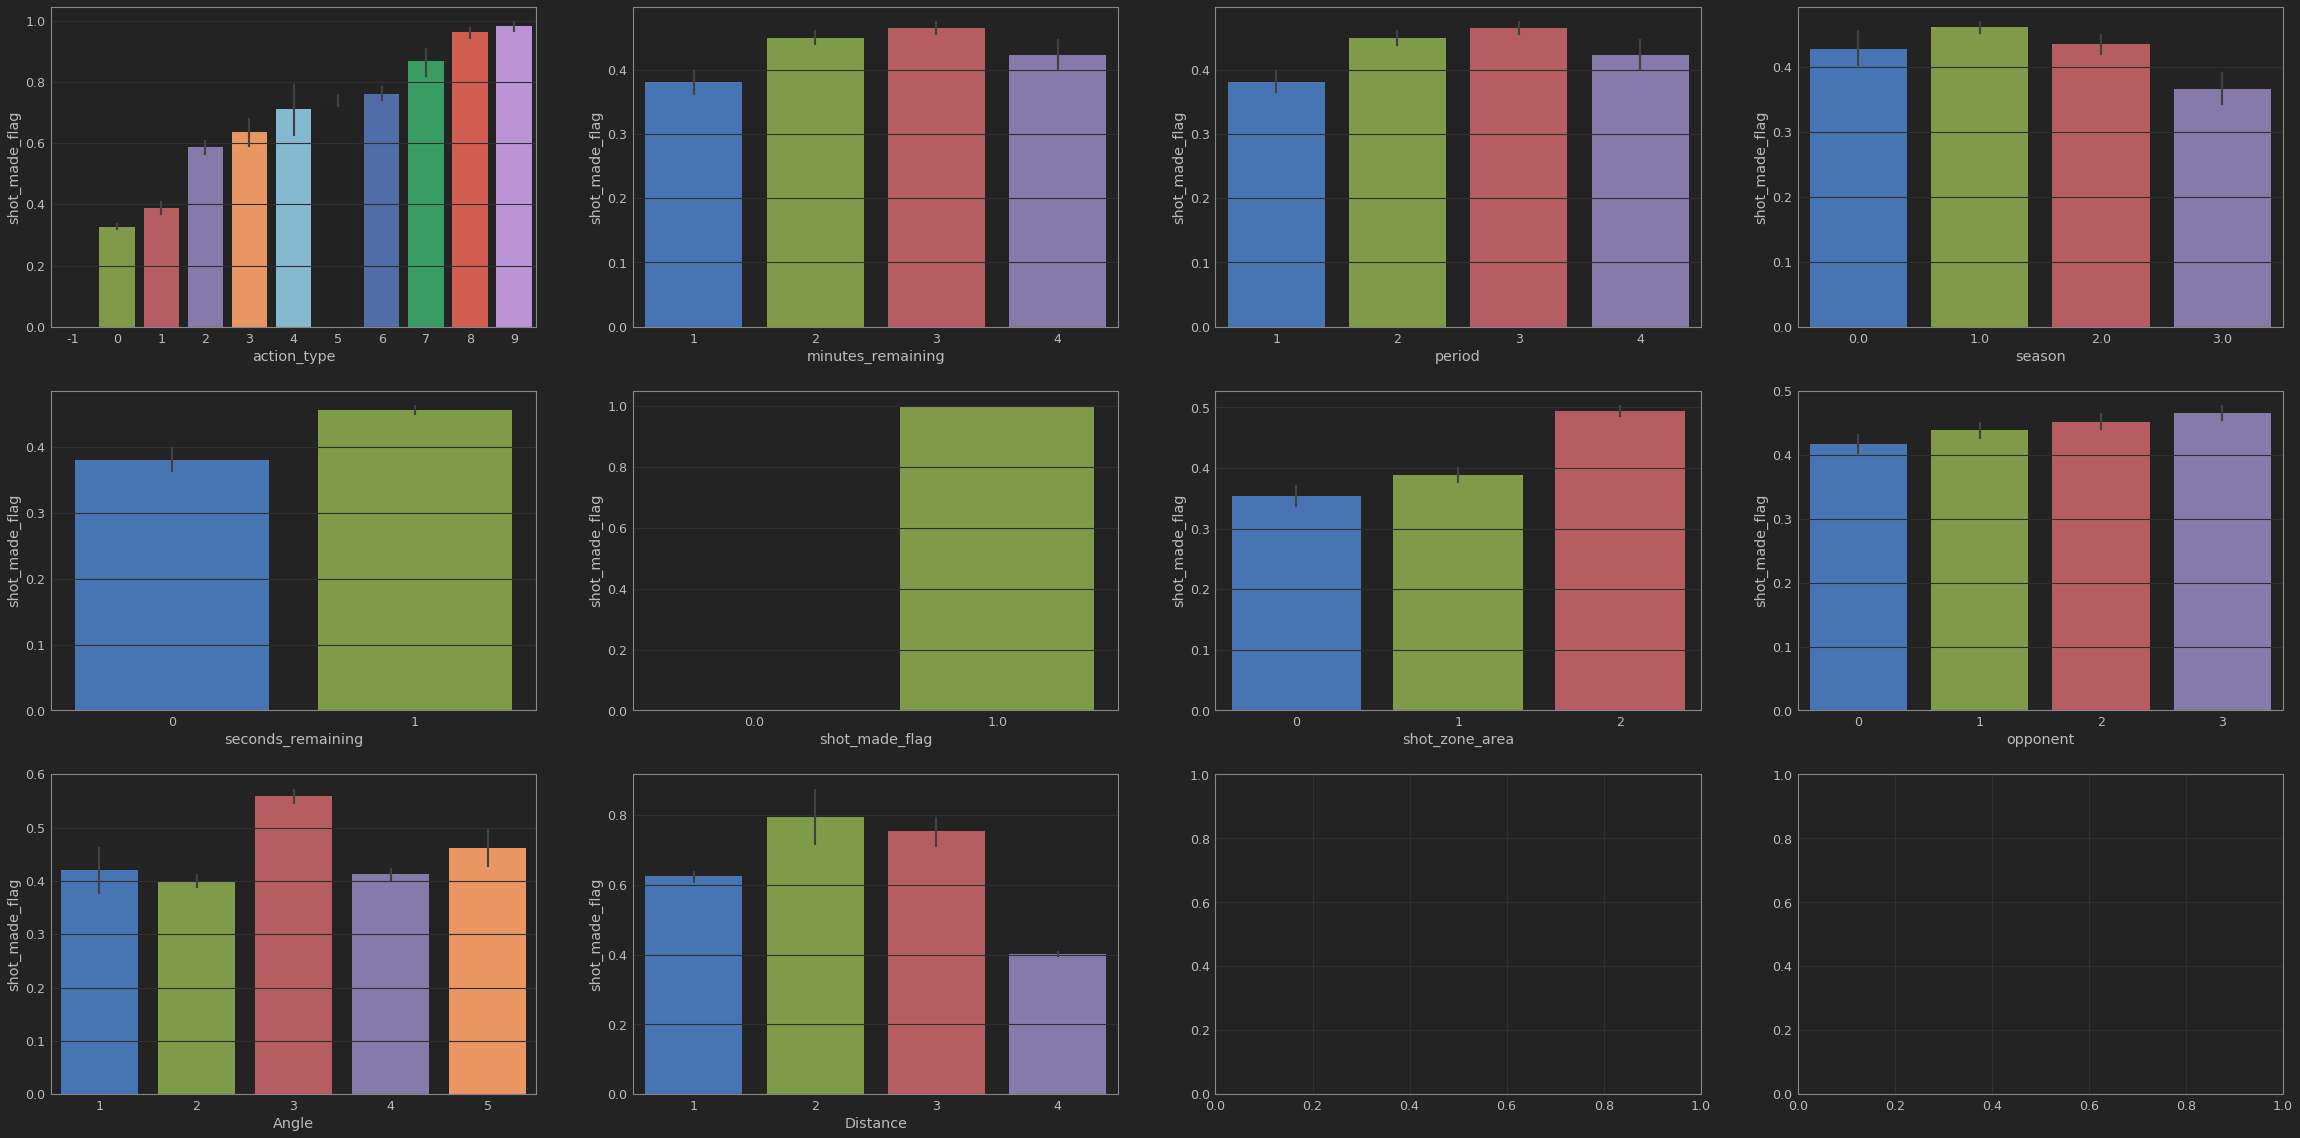

In [118]:
fig, ax = plt.subplots(ncols=4,nrows=ceil(len(numerical.columns)/4),figsize=(40,20))
for col,ax in zip(numerical.columns,chain(*ax)):
    if len(data[col].unique())<60:
        sns.factorplot(data=data,x=col,y='shot_made_flag',ax=ax,kind='bar')
        plt.close(2)
    else:
        g=sns.distplot(data[data[target]==0][col],ax=ax,color='grey')
        sns.distplot(data[data[target]==1][col],color='green',ax=ax)

In [148]:
_data=data.drop('shot_made_flag',axis=1)
for col in _data:
    _data[col]=_data[col].astype('category')
_data=pd.get_dummies(_data,drop_first=True)
_data['shot_made_flag']=data.shot_made_flag
data=_data

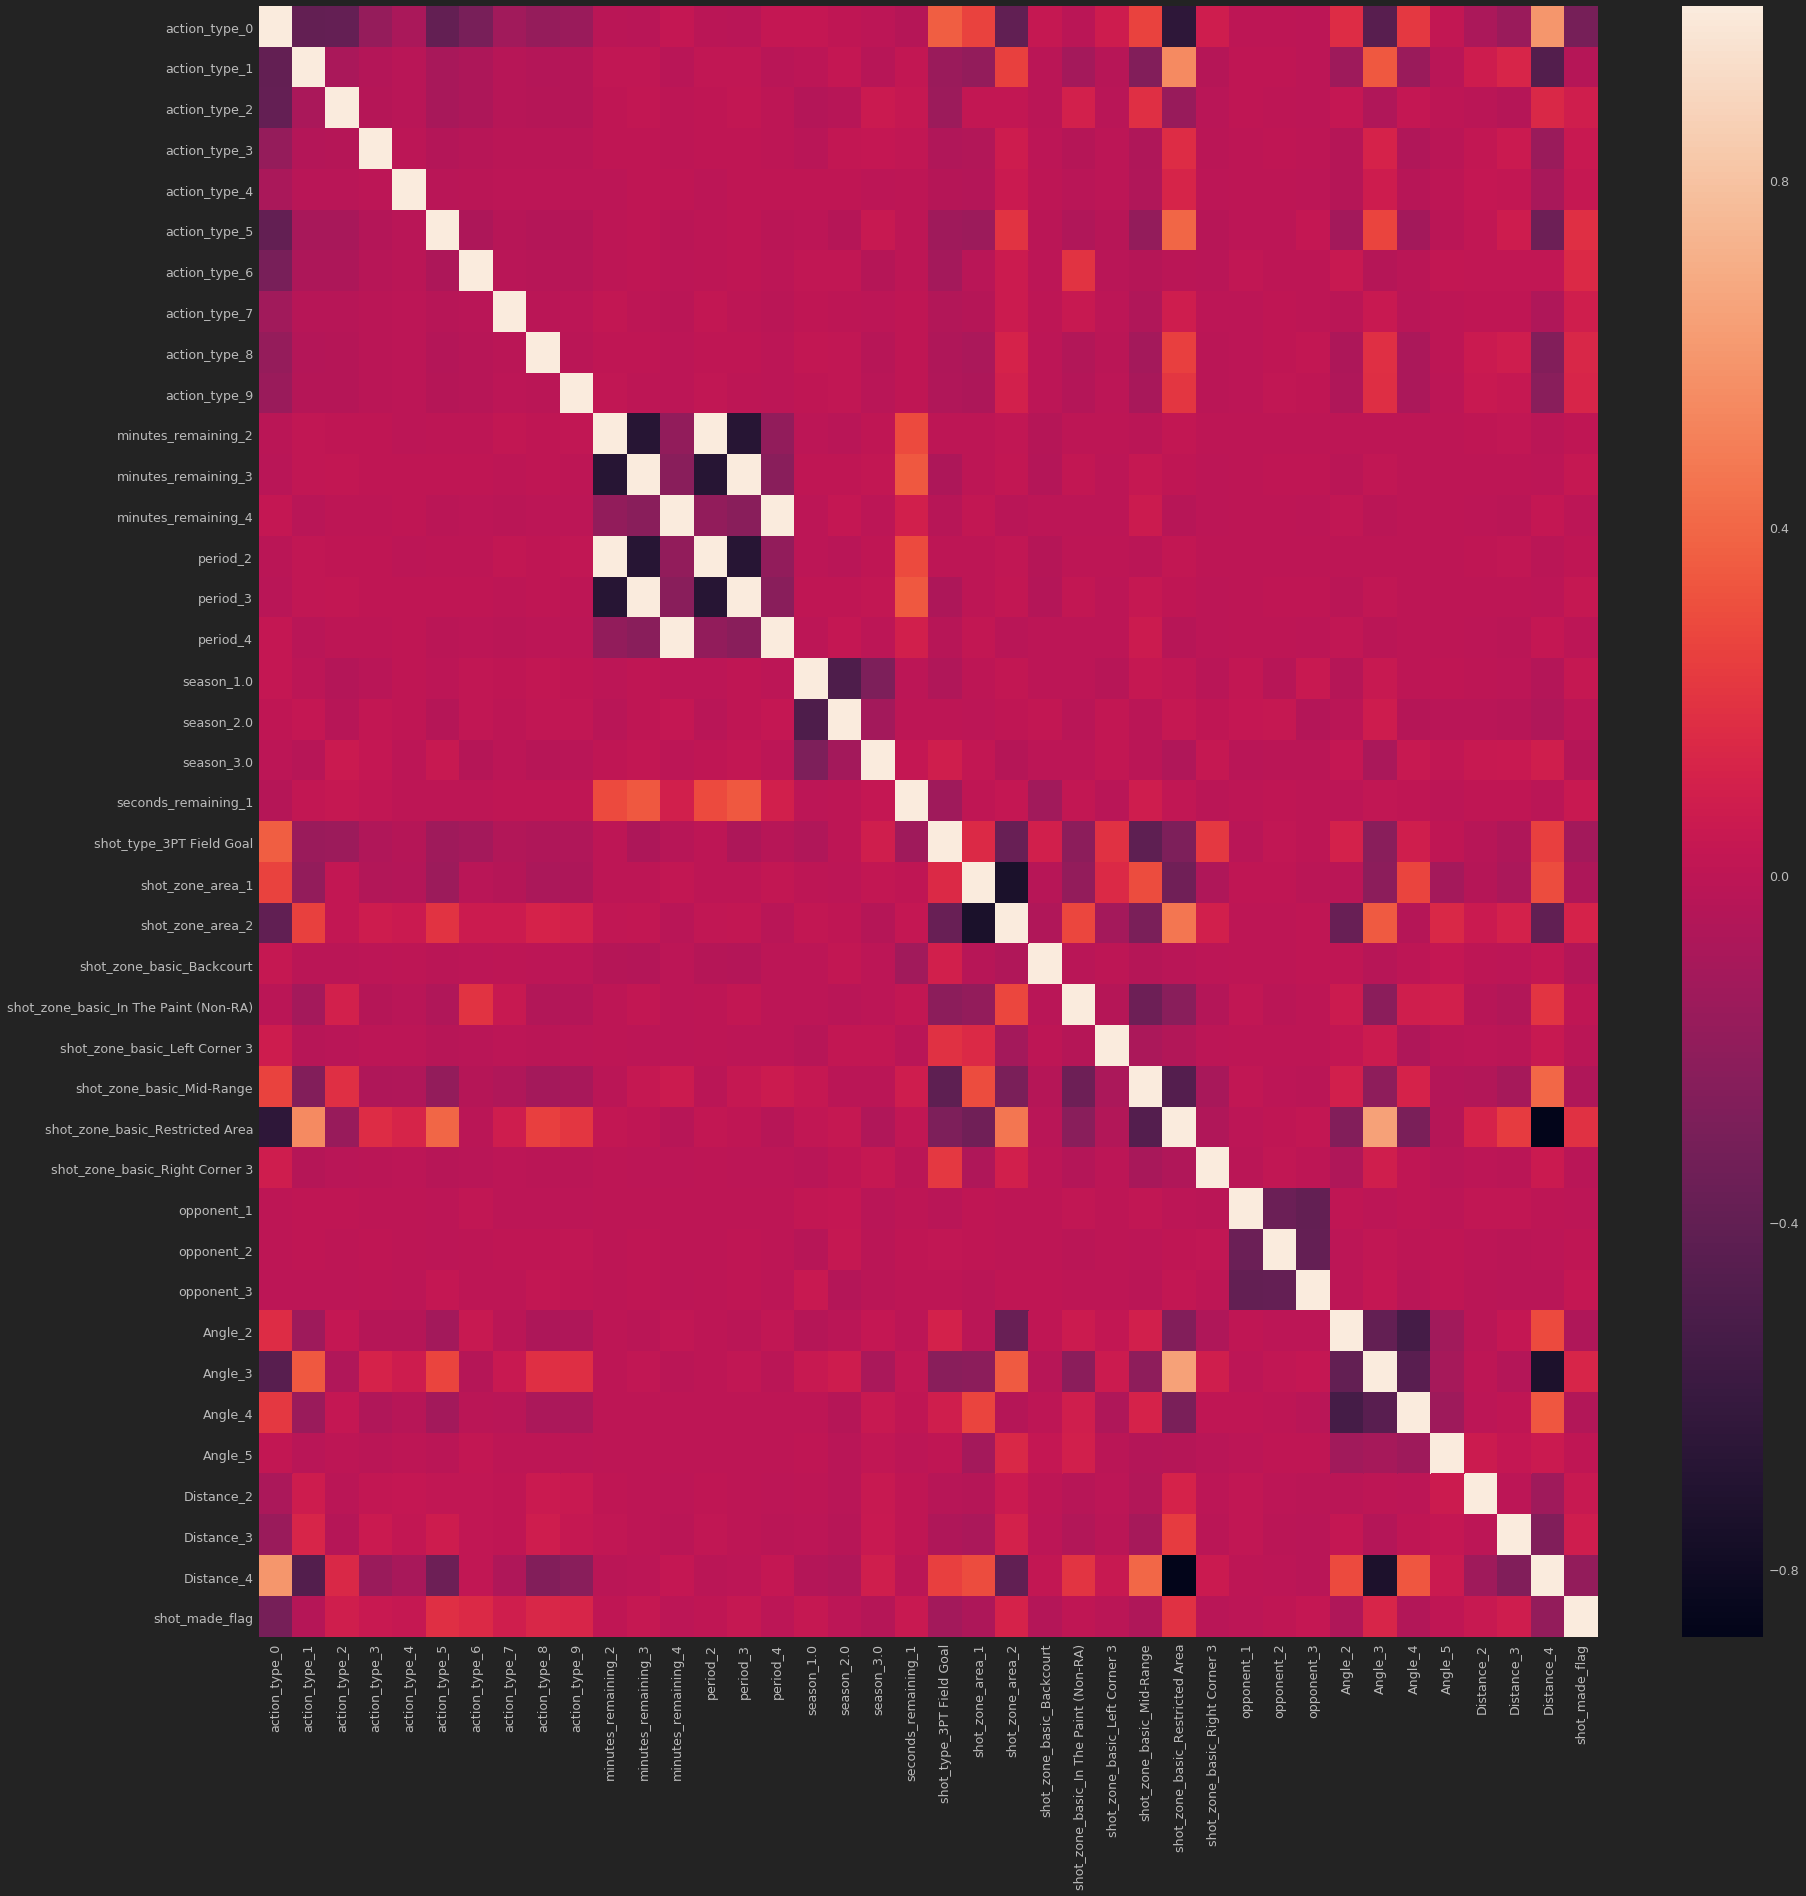

In [153]:
plt.figure(figsize=(30,30))
sns.heatmap(data.corr())
data.to_csv('preprocessed_kobe.csv')